In [1]:
# load important packages
import time
import os
from copy import copy
from IPython.display import HTML, YouTubeVideo

import astropy
import numpy as np
from astropy.io import fits, ascii
from astropy import units as u
from astropy.modeling import models
from astropy.utils.data import download_file
from specutils.fitting import fit_lines
from specutils import Spectrum1D
from jdaviz import Cubeviz
from jdaviz.app import Application
from specutils.manipulation import extract_region
from specutils.spectra import SpectralRegion

In [2]:
# load and configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# Save and Load Objects Using Pickle
import pickle


def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

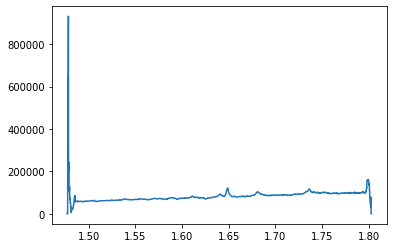

In [4]:
# This cell accesses the datacube file, defines the wavelength grid from header information and then plots a simple
# 1-D collapsed spectrum of the IFU data.

# Read in a 3-D IFU datacube of interest, and header.
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
cube = fits.getdata(cube_file)
header_cube = fits.getheader(cube_file)

# grab data information and wavelength definitions.
nz, ny, nx = cube.shape
crdelt3 = header_cube['CDELT3']
crval3 = header_cube['CRVAL3']

# define the wavelength grid (microns) from the header (Angstroms)
# and the AGN redshift and the emission line of interest.
wave = ((crdelt3 * (np.arange(0, nz, 1))) + crval3)/10000.0
redshift = 0.00332
emission_line = 1.64400*(1 + redshift)
emission_line_index = (np.abs(wave-emission_line)).argmin()

# make a simple summed 1d spectrum of the full cube
flux1 = np.sum(cube, axis=(1, 2))

# plot the full 1-D spectrum.
plt.figure(0)
plt.plot(wave, flux1)
plt.show()

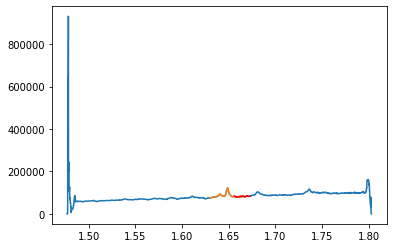

In [5]:
# This cell defines the wavelength regions of interest: around the emission line, and the location
# where you want to fit and remove the continuum very accurately.  Make a plot that shows the regions.

# Here we select a region that includes the emission line
# wavelength plus a small range of continuum around it.  
# Determine these limits by investigating the flux in the above plot.  Read
# the wavelength values off of the plot information at the lower right.

wave_emission_limit1 = 1.630
wave_emission_limit2 = 1.665

# Here we define a spectral range where we will use the
# flux to generate a continuum model.  The flux shape in this
# AGN is quite linear around the redward emission, so we will use only a 
# short segment of the spectrum on the red side of the emission 
# feature.
# We again determine these values by investigating the wavelengths in the
# above plot window.

continuum_limit1 = 1.656
continuum_limit2 = 1.673
  
# Define the wavelength region around the emission - indices
wavemin = (np.abs(wave-wave_emission_limit1)).argmin()
wavemax = (np.abs(wave-wave_emission_limit2)).argmin()

# Define the wavelength region used to fit the continuum flux level  - indices.
continuummin = (np.abs(wave-continuum_limit1)).argmin()
continuummax = (np.abs(wave-continuum_limit2)).argmin()

# Show the region used for the emission line and continuum fit.  Alter the wavelengths 
# above if this doesn't look good.  
plt.figure(1)
plt.plot(wave, flux1)
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')
plt.show()

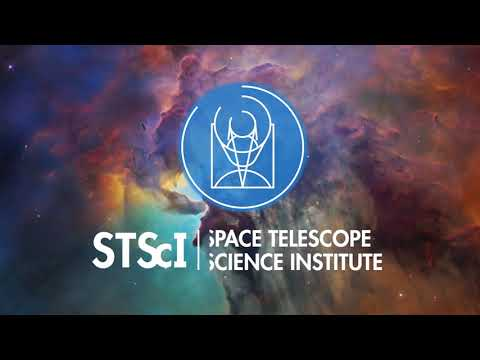

In [6]:
vid = YouTubeVideo("HMSYwiH3Gl4")
display(vid)

In [7]:
cubeviz = Cubeviz()
cubeviz.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [8]:
# Here, we load the data into the Cubeviz app.
cubeviz.load_data(fn) 

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that

In [9]:
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz1.mov" frameborder="0" allowfullscreen></iframe>')

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
# PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_1.mov" frameborder="0" allowfullscreen></iframe>')

In [11]:
# PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/cubeviz2_2.mov" frameborder="0" allowfullscreen></iframe>')

In [12]:
# Extract spectra corresponding to the colored regions in cubeviz
spectrum1 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 1') # AGN Center
spectrum2 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 2') # Red shifted component
spectrum3 = cubeviz.app.get_data_from_viewer('spectrum-viewer', 'Subset 3') # Blue shifted component
spectrum1

In [13]:
# Extract the line region defined in the spectral viewer
regions = cubeviz.specviz.get_spectral_regions()
        
if regions and "Subset 4" in regions.keys():
    line_region = regions["Subset 4"]
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)

In [14]:
# Extract the continuum region defined in the spectral viewer
if regions and "Subset 5" in regions.keys():
    continuum_region = regions["Subset 5"]
else:
    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)

In [15]:
# Apply the spectral region
# (creates new collapsed spectra if user did not in jdaviz)
if not spectrum1:
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_agn = extract_region(tmpspec, line_region)
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    
else: 
    spec_agn = extract_region(spectrum1, line_region)
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_red = extract_region(tmpspec, line_region)
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)
else:    
    spec_feii_red = extract_region(spectrum2, line_region)
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 
    spec_feii_blue = extract_region(tmpspec, line_region)
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)
else:     
    spec_feii_blue = extract_region(spectrum3, line_region)
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

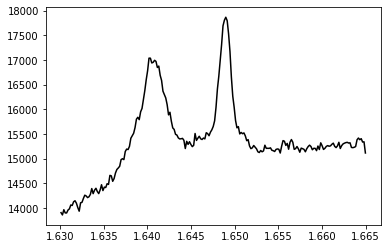

In [16]:
# Visualize new subsets
plt.figure()
plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')

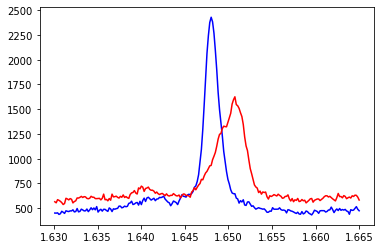

In [17]:
# Visualize new subsets
plt.figure()
plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')
plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')

In [18]:
# VIDEO OF CONTINUUM FITTING
# PART 1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p1.mov" frameborder="0" allowfullscreen></iframe>')

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [19]:
# PART 2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/bestfitcube_p2.mov" frameborder="0" allowfullscreen></iframe>')

In [20]:
# List data from viewer
regions = cubeviz.app.get_data_from_viewer("uncert-viewer")
regions

{}

In [21]:
# Extract continuum model from Cubeviz above
cont_psf_cube = cubeviz.app.get_data_from_viewer("uncert-viewer", "LinFitCont [Cube] 1")

In [22]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_ContinuumSubtract.fits"):
    os.remove("NGC4151_Hband_ContinuumSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumPSF.fits"):
    os.remove("NGC4151_Hband_ContinuumPSF.fits")
else:
    print("The file does not exist")

The file does not exist
The file does not exist


In [23]:
# Subtract Continuum

# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits', cache=True)
newheader_cube = fits.getheader(cube_file)

# Check to see if user made a continuum fit in Cubeviz, make continuum subtraction, and save output
if not cont_psf_cube:
    start_time = time.time()

    cont_sub_cube = np.zeros([nz, ny, nx])
    cont_psf_cube = np.zeros([nz, ny, nx])

    for i in range(1, nx-2):
        for j in range(1, ny-2):
            flux1 = cube[:, j, i]      
            cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)
            fitval = np.poly1d(cont_fit)
            continuum = fitval(wave)        
            cont_sub_cube[:, j, i] = flux1 - continuum
            cont_psf_cube[:, j, i] = continuum 

    del newheader_cube['MODE']
    fits.writeto('NGC4151_Hband_ContinuumSubtract.fits', cont_sub_cube, newheader_cube, overwrite=True)
    fits.writeto('NGC4151_Hband_ContinuumPSF.fits', cont_psf_cube, newheader_cube, overwrite=True)
    print('Continuum subtracted cube saved. PSF continuum cube saved.')
else:
    with fits.open(newfn, memmap=False) as cont_sub_cube:
        sci = cont_sub_cube['SCI'].data

        # Get List of different viewers
        continuumflux = cont_psf_cube["flux"]

        sci_contsub = sci-continuumflux
        cont_sub_cube['SCI'].data = sci_contsub 
        del cont_sub_cube['PRIMARY'].header['MODE']
        cont_sub_cube.writeto('NGC4151_Hband_ContinuumSubtract.fits')
        del newheader_cube['MODE']
        fits.writeto('NGC4151_Hband_ContinuumPSF.fits', continuumflux, newheader_cube, overwrite=True)

Continuum subtracted cube saved. PSF continuum cube saved.


In [24]:
# You can also read out your model fit parameters 
params = cubeviz.get_model_parameters(model_label="LinFitCont")
params

{}

In [25]:
# Open up a new instance of Cubeviz to visualize continuum subtracted data
cubeviz2 = Cubeviz()
cubeviz2.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [26]:
cont_sub_cube = 'NGC4151_Hband_ContinuumSubtract.fits'
cubeviz2.app.load_data(cont_sub_cube, data_label='Continuum Subtracted')

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that

In [27]:
# VIDEO PART1
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p1.mov" frameborder="0" allowfullscreen></iframe>')

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [28]:
# VIDEO PART2
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/multifit_p2.mov" frameborder="0" allowfullscreen></iframe>')

In [29]:
# Extract the spectral regions defined in the spectral viewer
regions = cubeviz2.specviz.get_spectral_regions()

if regions and "Subset 1" in regions.keys():
    line_region = regions["Subset 1"]
else:
    line_region = SpectralRegion(1.6322*u.um, 1.6563*u.um)

In [30]:
# List spectra available in spectrum-viewer
spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer') 
spec

{}

In [31]:
# Get gauss model spectrum and model cube
all_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer', 'Continuum Subtracted[SCI]') # AGN Center Data Cube
gauss_spec = cubeviz2.app.get_data_from_viewer('spectrum-viewer', 'GaussAll') # AGN Center Model Spec
gauss_cube = cubeviz2.app.get_data_from_viewer("uncert-viewer", "GaussAll [Cube] 1") # AGN Center Model Cube

In [32]:
# Check to see if user used Cubeviz (above), and, if not, read in premade data
if not gauss_cube:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)
    gauss_cube = fits.getdata(fn)
else:
    gauss_cube = gauss_cube["flux"]
    
if not all_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)
    all_spec = Spectrum1D.read(fn)
    
if not gauss_spec:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)
    gauss_spec = Spectrum1D.read(fn)

In [33]:
# Save your gauss model cube if necessary
if os.path.exists("gauss_model_cube.fits"):
    os.remove("gauss_model_cube.fits")
else:
    print("The file does not already exist")

fits.writeto('gauss_model_cube.fits', gauss_cube, overwrite=True)
print(type(gauss_cube))
print(type(all_spec.flux))

The file does not already exist
<class 'numpy.ndarray'>
<class 'astropy.units.quantity.Quantity'>


In [34]:
# You can also read out your model fit parameters 
params = cubeviz2.get_model_parameters(model_label="GaussAll")
params

{}

In [35]:
# Save parameters as a pickle file if necessary
save_obj(params, "gauss_params.pkl")
params = load_obj("gauss_params.pkl")

In [36]:
# Check to see if user used Cubeviz (above), and, if not, read in premade data
if not params:
    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)
    params = load_obj(fn)
    print("Loaded")

Loaded


In [37]:
# Overwrite gauss model with only 2 of the components of interest
gauss_cube_2component = gauss_cube*0

nz, ny, nx = gauss_cube_2component.shape
for i in range(0, nx-1):
    for j in range(0, ny-1):
        amp1 = params['GaussAll_3d']['amplitude_0'][i][j]
        amp2 = params['GaussAll_3d']['amplitude_2'][i][j]
        m1 = params['GaussAll_3d']['mean_0'][i][j]
        m2 = params['GaussAll_3d']['mean_2'][i][j]
        stdev1 = params['GaussAll_3d']['stddev_0'][i][j]
        stdev2 = params['GaussAll_3d']['stddev_2'][i][j]
        g1 = models.Gaussian1D(amplitude=amp1*u.Unit('count'), mean=m1*u.m, stddev=stdev1*u.m)
        g2 = models.Gaussian1D(amplitude=amp2*u.Unit('count'), mean=m2*u.m, stddev=stdev2*u.m)
        gauss_cube_2component[:, i, j] = g1(all_spec.spectral_axis)+g2(all_spec.spectral_axis)

In [38]:
# Add the continuum cube to the new model cube
continuum_file = 'NGC4151_Hband_ContinuumPSF.fits'
newfull_header = fits.getheader(continuum_file)

with fits.open(continuum_file, memmap=False) as continuum_cube: 
    continuum_data = continuum_cube[0].data
    full_model = gauss_cube_2component+continuum_data

In [39]:
# Subtract the model to create the final cube where the [Fe II] emission is isolated.
# Re-read in original IFU cube for manipulation
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'
newfinalsub_header = fits.getheader(cube_file)

with fits.open(cube_file, memmap=False) as original_cube:
    original_data = original_cube['SCI'].data
    final_sub_cube = original_data - full_model

In [40]:
# Delete any existing output in current directory
if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):
    os.remove("NGC4151_Hband_FinalSubtract.fits")
else:
    print("The file does not exist")

if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")
else:
    print("The file does not exist")

The file does not exist
The file does not exist


In [41]:
del newfinalsub_header['MODE']

fits.writeto('NGC4151_Hband_ContinuumandBrackettModel.fits', full_model, newfull_header, overwrite=True)
fits.writeto('NGC4151_Hband_FinalSubtract.fits', final_sub_cube, newfinalsub_header, overwrite=True)
print('Continuum subtracted cube saved. PSF continuum cube saved.')

Continuum subtracted cube saved. PSF continuum cube saved.


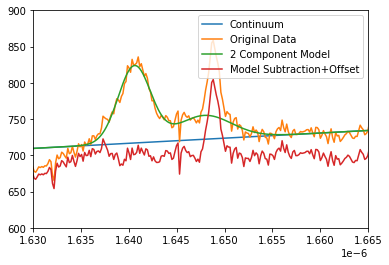

In [42]:
# Make the final plots to illustrate the original spectrum, model fits, and final continuum+gassian subtracted cube
plt.figure()
plt.xlim([1.630E-6, 1.665E-6])
plt.ylim([600, 900])
plt.plot(all_spec.spectral_axis, continuum_data[:, 30, 30], label='Continuum')
plt.plot(all_spec.spectral_axis, original_data[:, 30, 30], label='Original Data')
plt.plot(all_spec.spectral_axis, full_model[:, 30, 30], label='2 Component Model')
plt.plot(all_spec.spectral_axis, final_sub_cube[:, 30, 30]+700, label='Model Subtraction+Offset')
plt.legend()
plt.show()

In [43]:
# Open up a new instance of Cubeviz to visualize continuum subtracted data
cubeviz3 = Cubeviz()
cubeviz3.app

Application(config='cubeviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'd…

In [44]:
cont_sub_cube = 'NGC4151_Hband_FinalSubtract.fits'
cubeviz3.app.load_data(cont_sub_cube, data_label='Red/Blue Shift')

/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that the spectral axis is not last. Reshaping arrays to put spectral axis last.
  warnings.warn("Input WCS indicates that the spectral axis is not"
/Users/gough/opt/miniconda3/envs/py3810/lib/python3.8/site-packages/specutils/spectra/spectrum1d.py:202: UserWarning: Input WCS indicates that